In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [2]:
# load the digit images from sklearn
dataset = datasets.load_digits()

In [3]:
images = dataset.images
data = dataset.data
target = dataset.target

instead of using SVC, we will create our own simple model to classify the digits.

our model will be similar to a linear regressor: it will look at multiple images of the same digit, and find the 'impact pixels'. An impact pixel is one that consistently has either a very low or very high value across all images of that digit. These pixels will have higher absolute coefficient values.

A pixel that doesn't follow a consistent pattern over multiple images of the same digit is a low-impact pixel, which will have a coefficient close to 0.

As an example, let's look at all the images for the digit 0, and see which pixels always have a value greater than 10:

In [8]:
zero_images = images[target == 0]

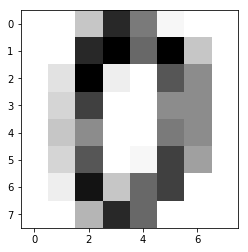

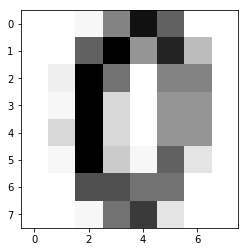

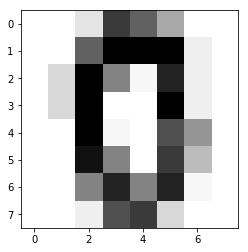

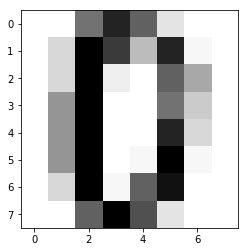

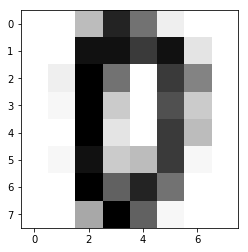

In [11]:
for image in zero_images[:5]:
    plt.imshow(image, cmap="Greys")
    plt.show()

In [13]:
# for a single image, it's easy to find the pixels greater than 10:
image = zero_images[0]
image > 10

array([[False, False, False,  True, False, False, False, False],
       [False, False,  True,  True, False,  True, False, False],
       [False, False,  True, False, False,  True, False, False],
       [False, False,  True, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False,  True, False, False,  True, False, False],
       [False, False,  True, False, False,  True, False, False],
       [False, False, False,  True, False, False, False, False]])

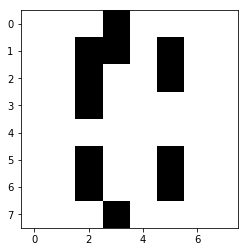

In [14]:
plt.imshow(image > 10, cmap="Greys")
plt.show()

In [19]:
# Now, we just have to figure out how to apply this logic over multiple images.
# We want to find the pixels that are greater than 10 in ALL images
# with 2 images, we can simply use the AND operation:
image2 = zero_images[1]
impact_pixels = (image > 10) & (image2 > 10)

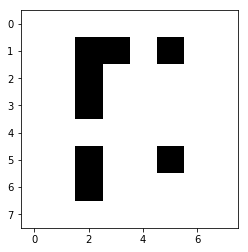

In [20]:
plt.imshow(impact_pixels, cmap="Greys")
plt.show()

In [71]:
# For convenience, let's create a function to plot a digit image
# we also include a cmap parameter that defaults to "Greys", so we can easily change it if needed
# **kwargs (short for keyword arguments) is a convenient shortcut that allows us to pass
# whatever other keyword arguments we want into the function, and they will then be passed to imshow
def show(img, cmap="Greys", **kwargs):
    plt.imshow(img, cmap=cmap, **kwargs)
    plt.show()

In [69]:
# As you can see, a lot of the original impact pixels are still there, but some are now gone.
# that's because those pixels did not meet the condition in the second image.
# to do this for all the images, we will use numpy's apply_along axis function
# if we pass axis=0, it will apply our function to each 'coordinate'
impact_pixels = np.apply_along_axis(lambda pixels: np.all(pixels > 10), 0, zero_images[:5])

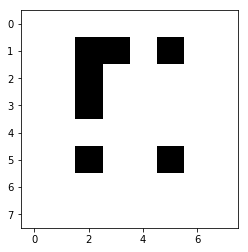

In [70]:
show(impact_pixels)

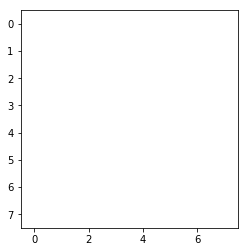

In [35]:
# However, that's just for 5 images. if you do the same for all the zero images, you will notice something strange:
impact_pixels = np.apply_along_axis(lambda pixels: np.all(pixels > 10), 0, zero_images)
show(impact_pixels)

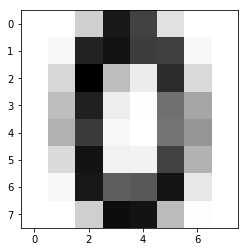

In [36]:
# That doesn't look good: there are no pixels that are ALWAYS greater than 10 in every image.
# So our condition for determining impact pixels is a bit too harsh.
# What if we just take the average of the pixel values?
impact_pixels = np.apply_along_axis(np.mean, 0, zero_images)
show(impact_pixels)

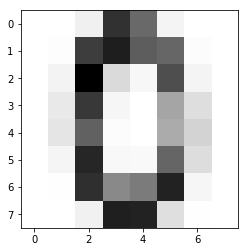

In [118]:
# This basically shows our 'average zero': what the combined values of all the zero images looks like.
# However, one big problem when using averaging is that it introduces too much error:
# We only really care about those highly dark pixels, the lighter colored ones are not very useful for prediction,
# because they may have values of 0 in one image, but 16 in another. We're looking for consistently dark pixels.

# To attempt to fix this, instead of taking the simple mean, we will use the square mean.
# This simply means we square the pixel values before averaging them.
# The benefit is that higher values are weighed much more strongly, so as a result,
# we should see more focus on the darker pixels, with the lighter ones starting to disappear.
pixel_weights = np.apply_along_axis(lambda pixels: np.mean(pixels ** 2), 0, zero_images)
show(pixel_weights)

In [53]:
# That looks a lot better: there are some pixels that are clearly defined, and fewer light ones.
# If you want to give even more weight to the higher value pixels, you're free to raise the exponent.

# Now that we have the squared average value of each pixel, we need to give each pixel a coefficient for our linear model.
# Remember the goal:
# the very dark pixels should have the most positive coefficients
# the lighter pixels should have coefficients near 0
# the white pixels should have negative coefficients

# Right now, we don't really have a good 'sense' of what values should get what coefficients,
# so we will use the following arbitrary rules:
# if a pixel has a positive value, normalize its value by dividing it by the total of all the positive pixels.
# At the end, all positive coefficients should add up to 1, with the darker ones having higher coefficients.
# if a pixel is zero, its coefficient is -1 / (total number of zero pixels)
# this way, every zero pixel is equal value, and all their coefficients add up to -1.
# These rules mean that both a completely black image (all values 16) and a completely white image (all values 0)
# will both result in a 'score' of 0
def create_coefs(pixel_weights):
    # make a copy of input array so we don't modify it
    coefs = pixel_weights.copy()
    # add up all the weights, and divide each weight by total (normalizing)
    total = np.sum(coefs)
    coefs = coefs / total
    # give each zero a negative coefficient, such that all negative coefs add to -1
    zeros = len(coefs[coefs == 0])
    coefs[coefs == 0] = -1 / zeros
    return coefs

In [119]:
coefs = create_coefs(pixel_weights)

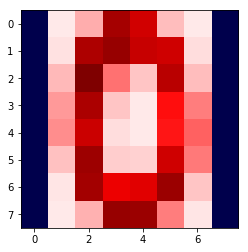

In [120]:
# let's see what we've got:
show(coefs, cmap="seismic")

In [77]:
# at first glance, it makes sense:
# the deep red pixels are the 'skeleton' pixels of a zero: they have the biggest impact on our model predicting a zero
# the lighter colors are the 'skin' pixels: their presence in the image doesn't really affect the final prediction too much
# the outer pixels are the dark blues, which are negative coefficients. Any dark pixels found in this area will
# REDUCE the chances of our model predicting a zero.

# let's use this coef matrix to see what score we get for some actual images.
# We will compare scores for zeros and non zeros

# to compute the score of an image, simply multiply the pixel values and the corresponding coefficients,
# and add them all up, then divide by 16 (the max pixel value)
# e.g. here's the score for the first image:
np.sum(image * coefs) / 16

0.6599032656421515

In [123]:
# this number by itself doesn't really help us much, we have to compare to other zero images and non-zero images
# put that bit of code into a function
def compute_linear_score(image, coefs):
    return np.sum(image * coefs) / 16

# try it on some zero images:
for img in zero_images[:10]:
    print(compute_linear_score(img, coefs))

0.65810999658574
0.6972412626331447
0.7650260930607844
0.7541893582262996
0.7746488900592978
0.7007976239506509
0.6812757696247222
0.8096813217013732
0.8067177670127369
0.6661453732184224


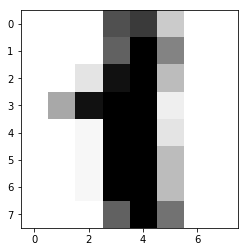

SCORE:  0.47856460989400484


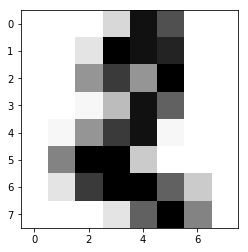

SCORE:  0.5682221389496633


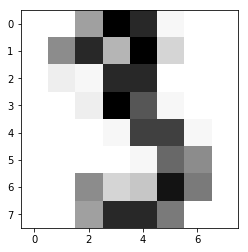

SCORE:  0.4466606087793943


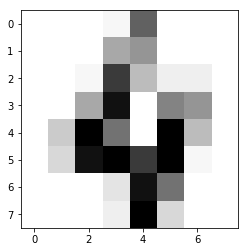

SCORE:  0.43608645044040895


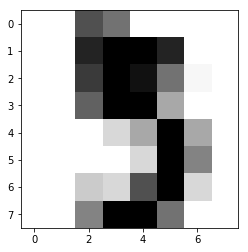

SCORE:  0.6325632365347251


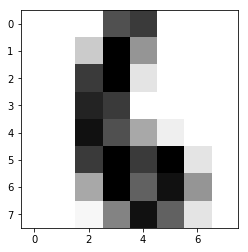

SCORE:  0.5971463178813827


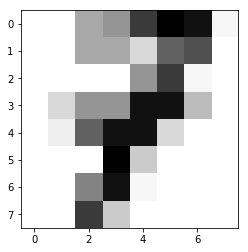

SCORE:  0.35435555101447924


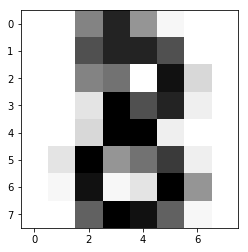

SCORE:  0.6490021136259594


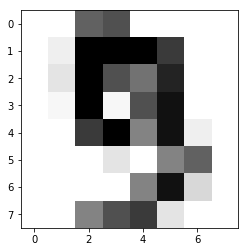

SCORE:  0.6344660549068122


In [124]:
# try it on some non zero images:
non_zeros = images[target != 0]
for img in non_zeros[:9]:
    show(img)
    print("SCORE: ", compute_linear_score(img, coefs))

In [83]:
# As we can see, zero's get higher scores, e.g. 0.65 or higher, while other numbers get low scores.
# Let's use a threshold of 0.65 to mark the distinction between a zero and a non-zero
# Using this threshold, we will have our model make some predictions on our data.

In [148]:
# first, as always, split the data into training and testing sets
train_X, test_X, train_Y, test_Y = train_test_split(data, target, test_size=0.2)

In [149]:
print(train_X.shape, test_X.shape, train_Y.shape, test_Y.shape)

(1437, 64) (360, 64) (1437,) (360,)


In [150]:
# NOTE: so far, for the sake of visualization, we've been using the 'images' array as our data array.
# But an actual model can only work with 2D arrays, where each row is a 1D array of feature values.
# So now we will switch to using the 'data' array, which has all our image data in 1D shape.

# Create the pixel weights of the zero images
pixel_weights = np.apply_along_axis(lambda pixels: np.mean(pixels ** 2), 0, train_X[train_Y == 0])
pixel_weights.shape

(64,)

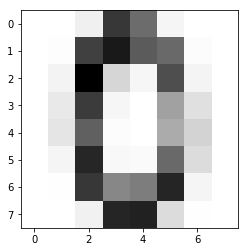

In [151]:
show(pixel_weights.reshape((8,8)))

In [152]:
# create the coefficients array from pixel weights
coefs = create_coefs(pixel_weights)
coefs.shape

(64,)

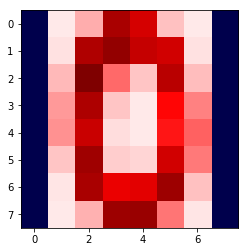

In [153]:
show(coefs.reshape((8,8)), cmap="seismic")

In [154]:
# Now use this coef matrix, and the threshold of 0.65 we set previously, to label each row in test_X
# as either 'zero' or 'non-zero'
predicted = np.array(['zero' if compute_linear_score(row, coefs) > 0.65 else 'non-zero' for row in test_X])

In [155]:
# let's create the 'expected' results, by looking at test_Y and replacing 0 with 'zero' and anything else with 'non-zero'
expected = np.array(['zero' if digit == 0 else 'non-zero' for digit in test_Y])

In [156]:
# Now for the moment of truth: compare our results with the expected results
# create the comparison array, which has True if the results match, else false
match = predicted == expected

In [157]:
# count the number of True's, and divide by the total length of the array
# this is basically our accuracy
acc = np.sum(match) / len(match)
acc

0.9027777777777778

In [158]:
# For such a ridiculously simple model we just made without any fine-tuning, that score isn't too bad.

In [159]:
# let's look at where the model failed:
# Total failures:
total_fail = np.sum(match == False)
# False positives (it thought a digit was zero when it wasn't):
false_positives = (expected == 'non-zero') & (predicted == 'zero')
# False negatives (it though a digit was NOT zero when it was):
false_negatives = (expected == 'zero') & (predicted == 'non-zero')
print("Total failures: ", total_fail)
print("False positives: ", np.sum(false_positives))
print("False negatives: ", np.sum(false_negatives))

Total failures:  35
False positives:  25
False negatives:  10


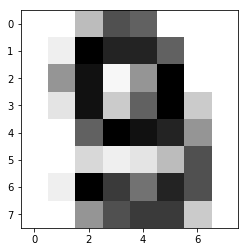

Score:  0.7295285918084369


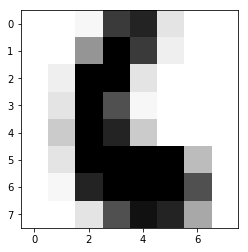

Score:  0.714225360361733


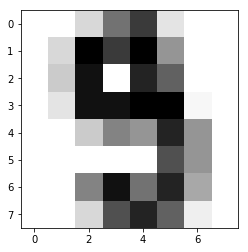

Score:  0.6723949722681455


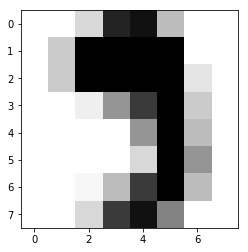

Score:  0.6872396567421166


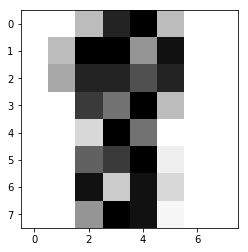

Score:  0.6517877379873074


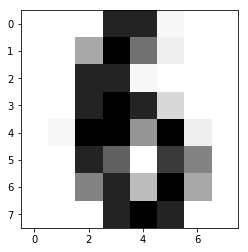

Score:  0.6717979802981935


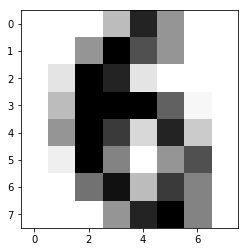

Score:  0.6768706859443686


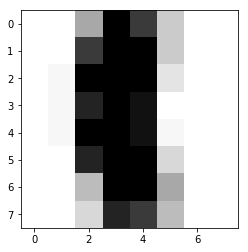

Score:  0.6554011167023472


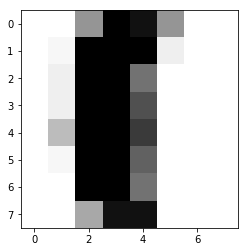

Score:  0.6584314312760461


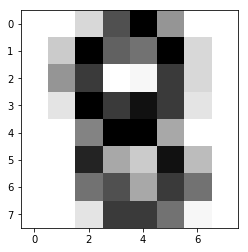

Score:  0.7102748567695436


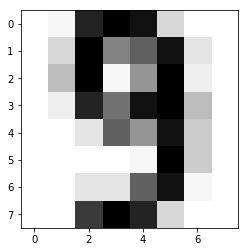

Score:  0.6799581403277539


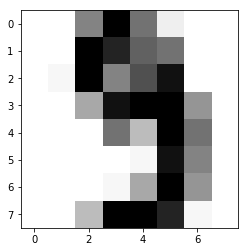

Score:  0.6502671048020296


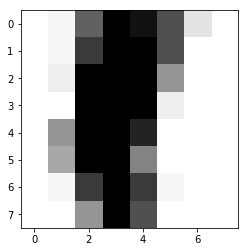

Score:  0.698991529975544


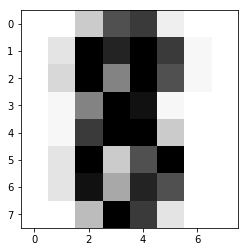

Score:  0.7260048511698423


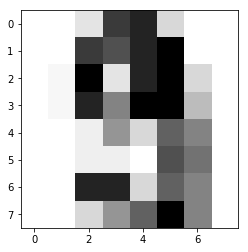

Score:  0.6738115633832862


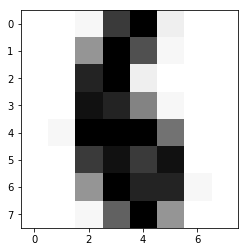

Score:  0.6606445275299602


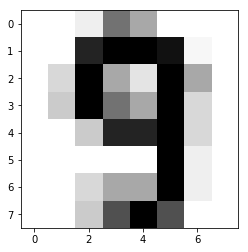

Score:  0.6843495727846894


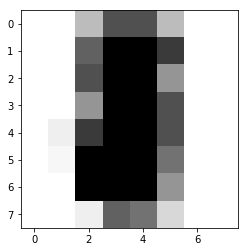

Score:  0.6974586355394379


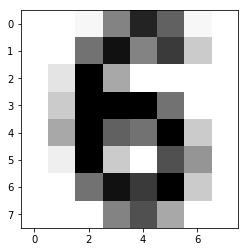

Score:  0.7033179658989615


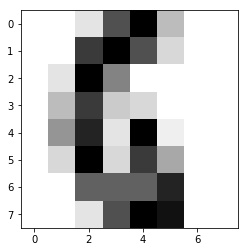

Score:  0.6531332614641503


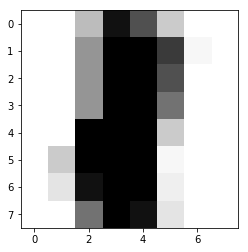

Score:  0.678091930335144


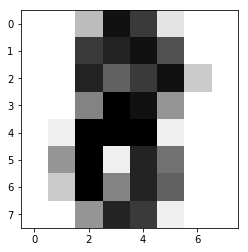

Score:  0.7227194311541478


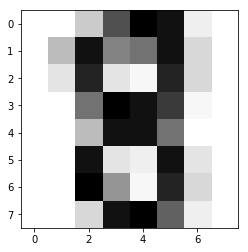

Score:  0.7004741889956345


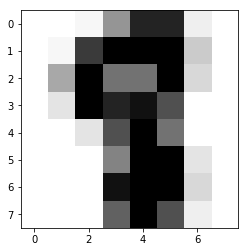

Score:  0.698219785420968


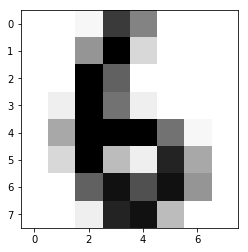

Score:  0.6524152045224254


In [162]:
# The numbers are great and all, but let's actually take a look at the images that confused our model.
# The false positives:
for img in test_X[false_positives]:
    # remember img is a 1D array, make sure to reshape it to visualize properly
    show(img.reshape((8,8)))
    print("Score: ", compute_linear_score(img, coefs))

In [163]:
# Looking at the false positives, you can see why our model would confuse these for zero's:
# these images have a lot of dark pixels where the 'skeleton' pixels of our coef matrix is,
# so these are significantly boosting the score.

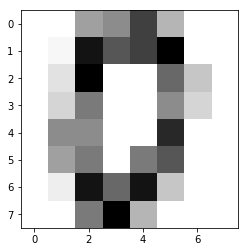

Score:  0.6068702526341452


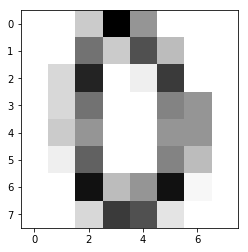

Score:  0.606805256100627


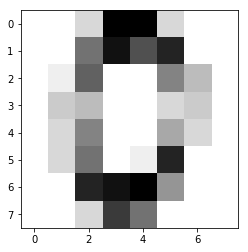

Score:  0.6368641291512072


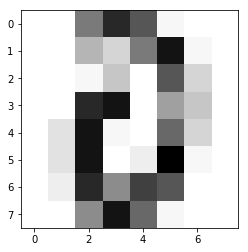

Score:  0.5834712624850484


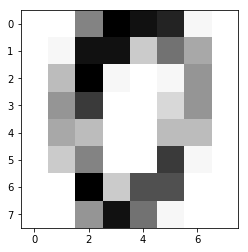

Score:  0.6397523084483112


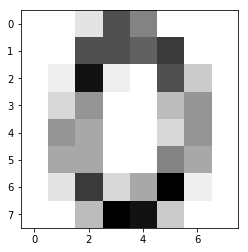

Score:  0.6274971287245632


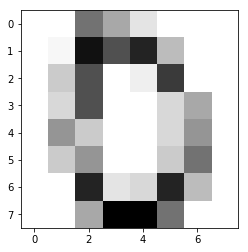

Score:  0.5868691765010627


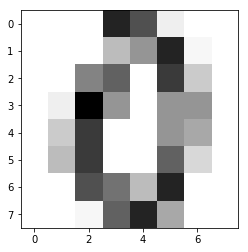

Score:  0.6164587888645938


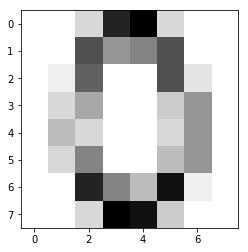

Score:  0.6062702846324386


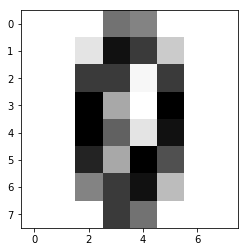

Score:  0.6387243870803081


In [164]:
# Now let's look at the false negatives:
for img in test_X[false_negatives]:
    # remember img is a 1D array, make sure to reshape it to visualize properly
    show(img.reshape((8,8)))
    print("Score: ", compute_linear_score(img, coefs))

In [165]:
# These are some poor zero's that just didn't make the cut for our threshold.
# The reason is mostly because their shape is different from the 'average zero' our model knows,
# so their score isn't that high.

In [166]:
# Now that we have looked at a very simple classification model, I'll leave you with a final challenge question:
# How can we improve it? (i.e. minimize false labeling as much as possible)